In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [10]:
data1 = pd.read_csv('../data/raw/Palworld_Data-comparison of ordinary BOSS attributes.csv')
data2 = pd.read_csv('../data/raw/Palworld_Data-hide pallu attributes.csv')
data3 = pd.read_csv('../data/raw/Palworld_Data--Palu combat attribute table.csv')
data4 = pd.read_csv('../data/raw/Palworld_Data-Palu Job Skills Table.csv')
data5 = pd.read_csv('../data/raw/Palworld_Data--Palu refresh level.csv')
data6 = pd.read_csv('../data/raw/Palworld_Data-Tower BOSS attribute comparison.csv')

In [14]:
df1 = data1.copy()
df2 = data2.copy()
df3 = data3.copy()
df4 = data4.copy()
df5 = data5.copy()
df6 = data6.copy()

In [16]:
df1

,"The BOSS version of each Palu only takes 20%~40% damage, has a capture rate of about 70%, has a riding sprint speed of 100 points, and is larger in size.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"In addition, a small number of BOSS have diffe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,name,HP,NaN,name,Remote attack,NaN,name,Riding speed (BOSS is 100 higher)
3,Chaos Knight BOSS,260,NaN,Melupa BOSS,90,NaN,Zixialu BOSS,1000
4,Chaos Knight,130,NaN,Melupa,75,NaN,Zixia Deer,900
...,...,...,...,...,...,...,...,...
112,NaN,NaN,NaN,NaN,NaN,NaN,Bihailong,800
113,NaN,NaN,NaN,NaN,NaN,NaN,Lightning Bear BOSS,650
114,NaN,NaN,NaN,NaN,NaN,NaN,Lightning Bear,550
115,NaN,NaN,NaN,NaN,NaN,NaN,White Velvet Snow Monster BOSS,650


In [30]:
def nettoyer_donnees_complet(df, nom_fichier="dataset"):
    """
    Fonction complète de nettoyage de données
    """
    print(f"\n🧹 === NETTOYAGE COMPLET : {nom_fichier} ===")
    df_clean = df.copy()
    rapport = {"etapes": [], "avant": df.shape, "supprime": 0}
    
    # === 1. TRAITEMENT DES VALEURS MANQUANTES ===
    print("\n📊 1. ANALYSE ET TRAITEMENT DES VALEURS MANQUANTES")
    
    missing_before = df_clean.isnull().sum().sum()
    print(f"Valeurs manquantes totales : {missing_before}")
    
    if missing_before > 0:
        # Colonnes avec beaucoup de NaN (>70%)
        colonnes_tres_vides = df_clean.columns[df_clean.isnull().mean() > 0.7].tolist()
        if colonnes_tres_vides:
            print(f"⚠️ Colonnes supprimées (>70% manquantes) : {colonnes_tres_vides}")
            df_clean.drop(columns=colonnes_tres_vides, inplace=True)
            rapport["etapes"].append(f"Supprimé {len(colonnes_tres_vides)} colonnes très vides")
        
        # Traitement par type de colonne
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                
                # Variables numériques
                if df_clean[col].dtype in ['int64', 'float64']:
                    if df_clean[col].isnull().mean() < 0.3:  # <30% manquant
                        # Imputation par la médiane (plus robuste)
                        mediane = df_clean[col].median()
                        df_clean[col].fillna(mediane, inplace=True)
                        print(f"  • {col}: remplacé par médiane ({mediane:.2f})")
                    else:
                        # KNN imputation pour beaucoup de manquants
                        imputer = KNNImputer(n_neighbors=5)
                        df_clean[[col]] = imputer.fit_transform(df_clean[[col]])
                        print(f"  • {col}: imputation KNN")
                
                # Variables catégorielles
                elif df_clean[col].dtype == 'object':
                    if df_clean[col].isnull().mean() < 0.3:
                        # Mode ou catégorie "Inconnu"
                        mode_val = df_clean[col].mode()
                        if len(mode_val) > 0:
                            df_clean[col].fillna(mode_val[0], inplace=True)
                            print(f"  • {col}: remplacé par mode ('{mode_val[0]}')")
                        else:
                            df_clean[col].fillna("Inconnu", inplace=True)
                            print(f"  • {col}: remplacé par 'Inconnu'")
                    else:
                        df_clean[col].fillna("Manquant", inplace=True)
                        print(f"  • {col}: remplacé par 'Manquant'")
    
    # === 2. DETECTION ET TRAITEMENT DES DOUBLONS ===
    print("\n🔄 2. GESTION DES DOUBLONS")
    doublons = df_clean.duplicated().sum()
    if doublons > 0:
        print(f"⚠️ {doublons} lignes dupliquées trouvées")
        df_clean.drop_duplicates(inplace=True)
        rapport["supprime"] += doublons
        print(f"✅ {doublons} doublons supprimés")
    else:
        print("✅ Aucun doublon trouvé")
    
    # === 3. DETECTION DES OUTLIERS ===
    print("\n📈 3. DETECTION DES VALEURS ABERRANTES")
    
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    outliers_info = {}
    
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        if len(outliers) > 0:
            outliers_info[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(df_clean) * 100,
                'bounds': (lower_bound, upper_bound)
            }
    
    if outliers_info:
        print("⚠️ Outliers détectés :")
        for col, info in outliers_info.items():
            print(f"  • {col}: {info['count']} outliers ({info['percentage']:.1f}%)")
        
        # Option : Capping des outliers (plus conservateur que suppression)
        for col, info in outliers_info.items():
            if info['percentage'] < 5:  # Seulement si <5% d'outliers
                lower_bound, upper_bound = info['bounds']
                df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
                print(f"  ✅ {col}: outliers écrêtés")
    else:
        print("✅ Aucun outlier significatif détecté")
    
    # === 4. NETTOYAGE DES DONNEES TEXTE ===
    print("\n📝 4. NETTOYAGE DES DONNÉES TEXTE")
    
    text_cols = df_clean.select_dtypes(include=['object']).columns
    for col in text_cols:
        # Suppression des espaces
        df_clean[col] = df_clean[col].astype(str).str.strip()
        
        # Uniformisation de la casse pour certaines colonnes
        if any(keyword in col.lower() for keyword in ['nom', 'ville', 'pays', 'category']):
            df_clean[col] = df_clean[col].str.title()
        
        # Suppression des caractères spéciaux indésirables
    df_clean[col] = df_clean[col].str.replace(r'[^\w\s\-.]', '', regex=True)
        
    print(f"  ✅ {col}: nettoyé")
    
    # === 5. VERIFICATION DES TYPES DE DONNEES ===
    print("\n🔢 5. OPTIMISATION DES TYPES DE DONNÉES")
    
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # Tentative de conversion en numérique
            try:
                df_numeric = pd.to_numeric(df_clean[col], errors='coerce')
                if df_numeric.notna().sum() / len(df_clean) > 0.8:  # 80% convertible
                    df_clean[col] = df_numeric
                    print(f"  ✅ {col}: converti en numérique")
            except:
                pass
            
            # Vérification des dates
            if any(keyword in col.lower() for keyword in ['date', 'time', 'created', 'updated']):
                try:
                    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
                    print(f"  ✅ {col}: converti en datetime")
                except:
                    pass
    
    # === 6. RESUME FINAL ===
    print(f"\n📋 === RÉSUMÉ DU NETTOYAGE ===")
    print(f"Forme avant : {rapport['avant']}")
    print(f"Forme après : {df_clean.shape}")
    print(f"Lignes supprimées : {rapport['supprime']}")
    print(f"Valeurs manquantes restantes : {df_clean.isnull().sum().sum()}")
    
    # Statistiques de qualité
    qualite_score = (1 - df_clean.isnull().sum().sum() / (df_clean.shape[0] * df_clean.shape[1])) * 100
    print(f"Score de qualité : {qualite_score:.1f}%")
    
    return df_clean

# === FONCTIONS UTILITAIRES SUPPLEMENTAIRES ===

def analyser_qualite_donnees(df):
    """Analyse complète de la qualité des données"""
    print("📊 === ANALYSE DE QUALITÉ ===")
    
    # Informations générales
    print(f"Dimensions : {df.shape}")
    print(f"Mémoire utilisée : {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Valeurs manquantes par colonne
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nValeurs manquantes :")
        for col, count in missing[missing > 0].items():
            print(f"  • {col}: {count} ({count/len(df)*100:.1f}%)")
    
    # Types de données
    print(f"\nTypes de données :")
    types_count = df.dtypes.value_counts()
    for dtype, count in types_count.items():
        print(f"  • {dtype}: {count} colonnes")
    
    # Statistiques par type
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nColonnes numériques : {len(numeric_cols)}")
        print(df[numeric_cols].describe())
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"\nColonnes catégorielles : {len(categorical_cols)}")
        for col in categorical_cols[:5]:  # Limiter l'affichage
            unique_count = df[col].nunique()
            print(f"  • {col}: {unique_count} valeurs uniques")

def visualiser_nettoyage(df_avant, df_apres):
    """Comparaison visuelle avant/après nettoyage"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Comparaison Avant/Après Nettoyage', fontsize=16)
    
    # Valeurs manquantes
    missing_avant = df_avant.isnull().sum().sum()
    missing_apres = df_apres.isnull().sum().sum()
    
    axes[0,0].bar(['Avant', 'Après'], [missing_avant, missing_apres], 
                  color=['red', 'green'], alpha=0.7)
    axes[0,0].set_title('Valeurs Manquantes')
    axes[0,0].set_ylabel('Nombre')
    
    # Forme du dataset
    axes[0,1].bar(['Avant', 'Après'], [df_avant.shape[0], df_apres.shape[0]], 
                  color=['blue', 'lightblue'], alpha=0.7)
    axes[0,1].set_title('Nombre de Lignes')
    axes[0,1].set_ylabel('Lignes')
    
    # Types de données (avant)
    types_avant = df_avant.dtypes.value_counts()
    axes[1,0].pie(types_avant.values, labels=types_avant.index, autopct='%1.1f%%')
    axes[1,0].set_title('Types de Données - Avant')
    
    # Types de données (après)
    types_apres = df_apres.dtypes.value_counts()
    axes[1,1].pie(types_apres.values, labels=types_apres.index, autopct='%1.1f%%')
    axes[1,1].set_title('Types de Données - Après')
    
    plt.tight_layout()
    plt.show()

# === NETTOYAGE SPÉCIFIQUE PALWORLD ===

def nettoyer_donnees_palworld(df):
    """
    Nettoyage spécialisé pour les données Palworld
    """
    print("🎮 === NETTOYAGE DONNÉES PALWORLD ===")
    df_clean = df.copy()
    
    # 1. Nettoyage des noms de Pals
    if 'name' in df_clean.columns or 'pal_name' in df_clean.columns:
        name_col = 'name' if 'name' in df_clean.columns else 'pal_name'
        df_clean[name_col] = df_clean[name_col].str.strip()
        df_clean[name_col] = df_clean[name_col].str.replace(r'[^\w\s-]', '', regex=True)
        print(f"✅ Noms de Pals nettoyés")
    
    # 2. Gestion des statistiques de combat
    stats_cols = [col for col in df_clean.columns if any(stat in col.lower() 
                  for stat in ['hp', 'attack', 'defense', 'speed', 'stamina'])]
    
    for col in stats_cols:
        if df_clean[col].dtype == 'object':
            # Extraction des valeurs numériques si format "120 HP"
            df_clean[col] = df_clean[col].str.extract(r'(\d+)').astype(float)
        
        # Les stats ne peuvent pas être négatives
        df_clean[col] = df_clean[col].clip(lower=0)
        
        # Imputation par la moyenne pour les stats manquantes
        if df_clean[col].isnull().sum() > 0:
            mean_val = df_clean[col].mean()
            df_clean[col].fillna(mean_val, inplace=True)
            print(f"✅ {col}: valeurs manquantes remplacées par moyenne ({mean_val:.1f})")
    
    # 3. Nettoyage des types/éléments
    type_cols = [col for col in df_clean.columns if 'type' in col.lower()]
    for col in type_cols:
        if df_clean[col].dtype == 'object':
            # Standardisation des types
            df_clean[col] = df_clean[col].str.title()
            df_clean[col] = df_clean[col].str.strip()
            
            # Types communs Palworld
            type_mapping = {
                'Feu': 'Fire', 'Eau': 'Water', 'Plante': 'Grass',
                'Électrique': 'Electric', 'Glace': 'Ice', 'Dragon': 'Dragon',
                'Ténèbres': 'Dark', 'Neutre': 'Neutral'
            }
            df_clean[col] = df_clean[col].replace(type_mapping)
            df_clean[col].fillna('Neutral', inplace=True)
            print(f"✅ {col}: types standardisés")
    
    # 4. Gestion des aptitudes/skills
    skill_cols = [col for col in df_clean.columns if any(skill in col.lower() 
                  for skill in ['skill', 'ability', 'aptitude', 'talent'])]
    
    for col in skill_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.title()
            df_clean[col].fillna('Aucune', inplace=True)
            print(f"✅ {col}: aptitudes nettoyées")
    
    # 5. Nettoyage des données de localisation
    location_cols = [col for col in df_clean.columns if any(loc in col.lower() 
                     for loc in ['location', 'biome', 'habitat', 'zone'])]
    
    for col in location_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.title()
            df_clean[col].fillna('Inconnu', inplace=True)
            print(f"✅ {col}: localisations standardisées")
    
    # 6. Validation des données de niveau/rareté
    level_cols = [col for col in df_clean.columns if any(lvl in col.lower() 
                  for lvl in ['level', 'lvl', 'rarity', 'rank'])]
    
    for col in level_cols:
        if df_clean[col].dtype in ['int64', 'float64']:
            # Niveaux généralement entre 1 et 50 dans Palworld
            df_clean[col] = df_clean[col].clip(lower=1, upper=50)
            df_clean[col].fillna(1, inplace=True)  # Niveau par défaut
            print(f"✅ {col}: niveaux validés (1-50)")
    
    return df_clean

# === ANALYSES SPÉCIFIQUES PALWORLD ===

def analyser_donnees_palworld(df):
    """
    Analyses spécifiques aux données Palworld
    """
    print("🎮 === ANALYSE DONNÉES PALWORLD ===")
    
    # Distribution des types
    type_cols = [col for col in df.columns if 'type' in col.lower()]
    if type_cols:
        print(f"\n📊 Distribution des types:")
        for col in type_cols:
            print(f"\n{col}:")
            print(df[col].value_counts().head(10))
    
    # Statistiques de combat
    stats_cols = [col for col in df.columns if any(stat in col.lower() 
                  for stat in ['hp', 'attack', 'defense', 'speed'])]
    if stats_cols:
        print(f"\n⚔️ Statistiques de combat:")
        print(df[stats_cols].describe())
    
    # Répartition par rareté/niveau
    rarity_cols = [col for col in df.columns if any(rare in col.lower() 
                   for rare in ['rarity', 'rank', 'level'])]
    if rarity_cols:
        print(f"\n🌟 Répartition par rareté/niveau:")
        for col in rarity_cols:
            if df[col].dtype in ['int64', 'float64']:
                print(f"\n{col}:")
                print(df[col].value_counts().sort_index())
    
    # Habitats/Biomes
    location_cols = [col for col in df.columns if any(loc in col.lower() 
                     for loc in ['location', 'biome', 'habitat'])]
    if location_cols:
        print(f"\n🌍 Habitats/Biomes:")
        for col in location_cols:
            print(f"\n{col}:")
            print(df[col].value_counts().head(10))

def visualiser_donnees_palworld(df):
    """
    Visualisations spécifiques Palworld
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🎮 Analyse des Données Palworld', fontsize=16)
    
    # 1. Distribution des types
    type_cols = [col for col in df.columns if 'type' in col.lower()]
    if type_cols:
        type_counts = df[type_cols[0]].value_counts().head(8)
        axes[0,0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('Distribution des Types')
    
    # 2. Histogramme des HP/Attaque
    stats_cols = [col for col in df.columns if any(stat in col.lower() 
                  for stat in ['hp', 'health', 'attack'])]
    if stats_cols:
        df[stats_cols[0]].hist(bins=20, ax=axes[0,1], alpha=0.7, color='skyblue')
        axes[0,1].set_title(f'Distribution {stats_cols[0]}')
    
    # 3. Boxplot des statistiques
    numeric_stats = df.select_dtypes(include=[np.number]).columns[:4]
    if len(numeric_stats) > 0:
        df[numeric_stats].boxplot(ax=axes[1,0])
        axes[1,0].set_title('Boxplot des Statistiques')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Corrélation entre stats
    if len(numeric_stats) > 1:
        corr_matrix = df[numeric_stats].corr()
        sns.heatmap(corr_matrix, annot=True, ax=axes[1,1], cmap='coolwarm')
        axes[1,1].set_title('Corrélation entre Stats')
    
    plt.tight_layout()
    plt.show()

# === EXEMPLE D'UTILISATION PALWORLD ===
"""
# Chargement des données Palworld
df = pd.read_csv('palworld_data.csv')

# Analyse spécifique
analyser_donnees_palworld(df)

# Nettoyage spécialisé
df_clean = nettoyer_donnees_palworld(df)

# Nettoyage général ensuite
df_final = nettoyer_donnees_complet(df_clean, "Palworld Dataset")

# Visualisations
visualiser_donnees_palworld(df_final)

# Sauvegarde
df_final.to_csv('palworld_data_clean.csv', index=False)
print("🎮 Dataset Palworld nettoyé et prêt pour l'analyse !")
"""

'\n# Chargement des données Palworld\ndf = pd.read_csv(\'palworld_data.csv\')\n\n# Analyse spécifique\nanalyser_donnees_palworld(df)\n\n# Nettoyage spécialisé\ndf_clean = nettoyer_donnees_palworld(df)\n\n# Nettoyage général ensuite\ndf_final = nettoyer_donnees_complet(df_clean, "Palworld Dataset")\n\n# Visualisations\nvisualiser_donnees_palworld(df_final)\n\n# Sauvegarde\ndf_final.to_csv(\'palworld_data_clean.csv\', index=False)\nprint("🎮 Dataset Palworld nettoyé et prêt pour l\'analyse !")\n'

In [20]:
analyser_donnees_palworld(df1)

🎮 === ANALYSE DONNÉES PALWORLD ===

⚔️ Statistiques de combat:
       The BOSS version of each Palu only takes 20%~40% damage, has a capture rate of about 70%, has a riding sprint speed of 100 points, and is larger in size.
count                                                  12                                                                                                       
unique                                                 12                                                                                                       
top     In addition, a small number of BOSS have diffe...                                                                                                       
freq                                                    1                                                                                                       


In [22]:
df1_clean = nettoyer_donnees_palworld(df1)

🎮 === NETTOYAGE DONNÉES PALWORLD ===
✅ The BOSS version of each Palu only takes 20%~40% damage, has a capture rate of about 70%, has a riding sprint speed of 100 points, and is larger in size.: valeurs manquantes remplacées par moyenne (nan)


In [32]:
df1_final = nettoyer_donnees_complet(df1_clean)


🧹 === NETTOYAGE COMPLET : dataset ===

📊 1. ANALYSE ET TRAITEMENT DES VALEURS MANQUANTES
Valeurs manquantes totales : 681
⚠️ Colonnes supprimées (>70% manquantes) : ['The BOSS version of each Palu only takes 20%~40% damage, has a capture rate of about 70%, has a riding sprint speed of 100 points, and is larger in size.', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
  • Unnamed: 6: remplacé par mode ('Thunderbird')
  • Unnamed: 7: remplacé par mode ('800')

🔄 2. GESTION DES DOUBLONS
⚠️ 1 lignes dupliquées trouvées
✅ 1 doublons supprimés

📈 3. DETECTION DES VALEURS ABERRANTES
✅ Aucun outlier significatif détecté

📝 4. NETTOYAGE DES DONNÉES TEXTE
  ✅ Unnamed: 7: nettoyé

🔢 5. OPTIMISATION DES TYPES DE DONNÉES
  ✅ Unnamed: 7: converti en numérique

📋 === RÉSUMÉ DU NETTOYAGE ===
Forme avant : (117, 8)
Forme après : (116, 2)
Lignes supprimées : 1
Valeurs manquantes restantes : 1
Score de qualité : 99.6%


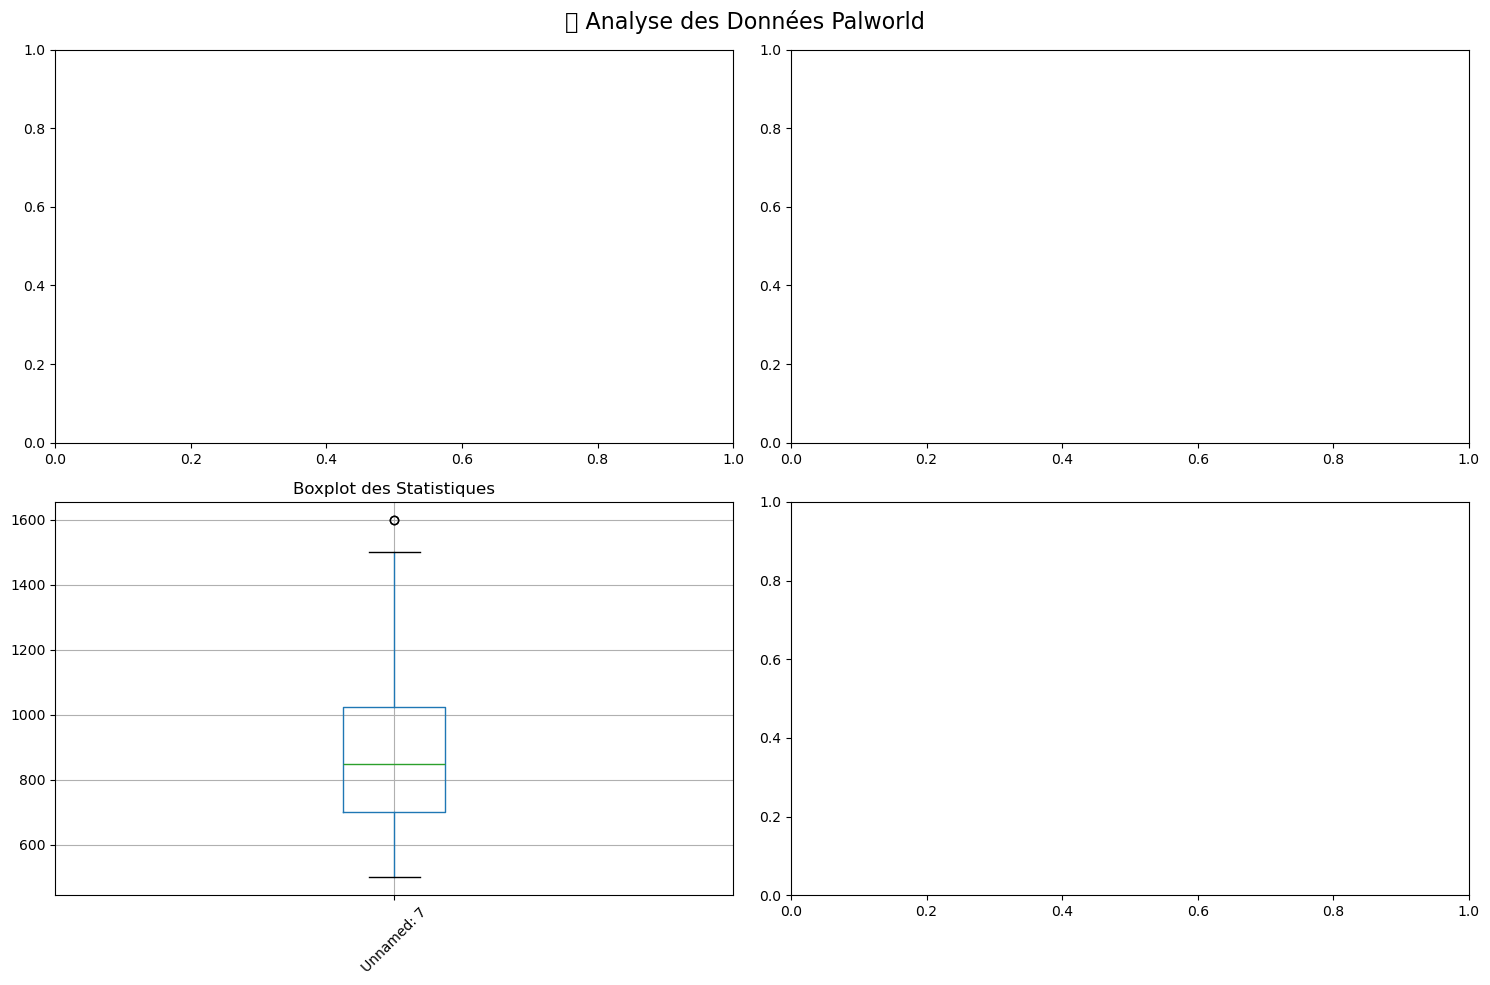

In [34]:
visualiser_donnees_palworld(df1_final)

In [36]:
df1_final

,Unnamed: 6,Unnamed: 7
0,Thunderbird,800.0
2,name,NaN
3,Zixialu BOSS,1000.0
4,Zixia Deer,900.0
5,Suzaku BOSS,1200.0
...,...,...
112,Bihailong,800.0
113,Lightning Bear BOSS,650.0
114,Lightning Bear,550.0
115,White Velvet Snow Monster BOSS,650.0


In [38]:
df1

,"The BOSS version of each Palu only takes 20%~40% damage, has a capture rate of about 70%, has a riding sprint speed of 100 points, and is larger in size.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"In addition, a small number of BOSS have diffe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,name,HP,NaN,name,Remote attack,NaN,name,Riding speed (BOSS is 100 higher)
3,Chaos Knight BOSS,260,NaN,Melupa BOSS,90,NaN,Zixialu BOSS,1000
4,Chaos Knight,130,NaN,Melupa,75,NaN,Zixia Deer,900
...,...,...,...,...,...,...,...,...
112,NaN,NaN,NaN,NaN,NaN,NaN,Bihailong,800
113,NaN,NaN,NaN,NaN,NaN,NaN,Lightning Bear BOSS,650
114,NaN,NaN,NaN,NaN,NaN,NaN,Lightning Bear,550
115,NaN,NaN,NaN,NaN,NaN,NaN,White Velvet Snow Monster BOSS,650


Le code plus haut n'est pas adapté à la structure spécifique de mon csv. Essaye avec une adaptation

In [41]:
def nettoyer_palworld_boss_data(fichier_path):
    """
    Nettoyage spécialisé pour le fichier Palworld BOSS comparison
    """
    print("🎮 === NETTOYAGE DONNÉES PALWORLD BOSS ===")
    
    # 1. Lecture manuelle du fichier (structure non-standard)
    with open(fichier_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # 2. Identifier où commencent les vraies données (après les lignes d'info)
    data_start = 0
    for i, line in enumerate(lines):
        if 'name,HP' in line:  # Ligne des headers
            data_start = i
            break
    
    print(f"📍 Données commencent à la ligne {data_start + 1}")
    
    # 3. Extraire les données par sections
    data_lines = [line.strip() for line in lines[data_start:] if line.strip()]
    
    # 4. Parser les 3 sections distinctes
    sections_data = {
        'hp_data': [],
        'attack_data': [],
        'speed_data': []
    }
    
    current_section = None
    for line in data_lines:
        cells = [cell.strip().strip('"') for cell in line.split(',')]
        
        # Identifier la section actuelle
        if len(cells) >= 7:
            # Ligne avec les headers de section
            if 'HP' in cells[1]:
                current_section = 'hp_data'
            elif 'Remote attack' in cells[4]:
                current_section = 'attack_data'  
            elif 'Riding speed' in cells[6]:
                current_section = 'speed_data'
            continue
        
        # Extraire les données selon la section
        if current_section and len(cells) >= 2:
            if current_section == 'hp_data' and cells[0] and cells[1]:
                sections_data['hp_data'].append({
                    'name': cells[0],
                    'hp': cells[1]
                })
            elif current_section == 'attack_data' and len(cells) >= 5 and cells[3] and cells[4]:
                sections_data['attack_data'].append({
                    'name': cells[3],
                    'remote_attack': cells[4]
                })
            elif current_section == 'speed_data' and len(cells) >= 7 and cells[6] and cells[7]:
                sections_data['speed_data'].append({
                    'name': cells[6],
                    'riding_speed': cells[7]
                })
    
    print(f"✅ Sections extraites:")
    print(f"  - HP: {len(sections_data['hp_data'])} entrées")
    print(f"  - Attack: {len(sections_data['attack_data'])} entrées")  
    print(f"  - Speed: {len(sections_data['speed_data'])} entrées")
    
    # 5. Créer DataFrames pour chaque section
    df_hp = pd.DataFrame(sections_data['hp_data']) if sections_data['hp_data'] else pd.DataFrame()
    df_attack = pd.DataFrame(sections_data['attack_data']) if sections_data['attack_data'] else pd.DataFrame()
    df_speed = pd.DataFrame(sections_data['speed_data']) if sections_data['speed_data'] else pd.DataFrame()
    
    # 6. Fusionner toutes les données
    all_names = set()
    if not df_hp.empty:
        all_names.update(df_hp['name'].tolist())
    if not df_attack.empty:
        all_names.update(df_attack['name'].tolist())
    if not df_speed.empty:
        all_names.update(df_speed['name'].tolist())
    
    # Créer le DataFrame final
    df_final = pd.DataFrame({'name': list(all_names)})
    
    # Merger les données
    if not df_hp.empty:
        df_final = df_final.merge(df_hp, on='name', how='left')
    if not df_attack.empty:
        df_final = df_final.merge(df_attack, on='name', how='left')
    if not df_speed.empty:
        df_final = df_final.merge(df_speed, on='name', how='left')
    
    print(f"🔗 DataFrame final: {df_final.shape}")
    
    # 7. Nettoyage spécialisé
    df_clean = nettoyer_donnees_palworld_boss(df_final)
    
    return df_clean

def nettoyer_donnees_palworld_boss(df):
    """
    Nettoyage spécialisé pour les données BOSS Palworld
    """
    print("\n🧹 === NETTOYAGE SPÉCIALISÉ PALWORLD BOSS ===")
    df_clean = df.copy()
    
    # 1. Nettoyage des noms
    if 'name' in df_clean.columns:
        print("📝 Nettoyage des noms de Pals...")
        
        # Suppression des espaces et caractères indésirables
        df_clean['name'] = df_clean['name'].str.strip()
        df_clean['name'] = df_clean['name'].str.replace(r'[^\w\s\-]', '', regex=True)
        
        # Identification BOSS vs Normal
        df_clean['is_boss'] = df_clean['name'].str.contains('BOSS', case=False, na=False)
        df_clean['pal_type'] = df_clean['name'].apply(lambda x: 'BOSS' if 'BOSS' in str(x) else 'Normal')
        
        # Nom de base (sans BOSS)
        df_clean['base_name'] = df_clean['name'].str.replace(' BOSS', '', case=False)
        df_clean['base_name'] = df_clean['base_name'].str.replace('BOSS', '', case=False).str.strip()
        
        print(f"  ✅ {df_clean['is_boss'].sum()} BOSS identifiés")
        print(f"  ✅ {(~df_clean['is_boss']).sum()} Pals normaux")
    
    # 2. Nettoyage des statistiques numériques
    numeric_cols = ['hp', 'remote_attack', 'riding_speed']
    for col in numeric_cols:
        if col in df_clean.columns:
            print(f"🔢 Nettoyage {col}...")
            
            # Conversion en numérique
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            
            # Les stats ne peuvent pas être négatives
            df_clean[col] = df_clean[col].clip(lower=0)
            
            # Statistiques avant imputation
            missing_before = df_clean[col].isnull().sum()
            print(f"  • Valeurs manquantes: {missing_before}")
            
            # Imputation intelligente basée sur le type (BOSS vs Normal)
            if missing_before > 0:
                for pal_type in ['BOSS', 'Normal']:
                    mask = df_clean['pal_type'] == pal_type
                    if mask.sum() > 0:
                        type_mean = df_clean.loc[mask, col].mean()
                        if not np.isnan(type_mean):
                            df_clean.loc[mask & df_clean[col].isnull(), col] = type_mean
                            print(f"  ✅ {col} {pal_type}: imputation par moyenne ({type_mean:.1f})")
            
            # Imputation générale pour les valeurs restantes
            remaining_missing = df_clean[col].isnull().sum()
            if remaining_missing > 0:
                overall_mean = df_clean[col].mean()
                if not np.isnan(overall_mean):
                    df_clean[col].fillna(overall_mean, inplace=True)
                    print(f"  ✅ {col}: {remaining_missing} valeurs imputées par moyenne globale")
    
    # 3. Calculs des ratios BOSS/Normal
    print("\n📊 Calcul des ratios BOSS/Normal...")
    
    # Grouper par nom de base pour calculer les ratios
    boss_stats = df_clean[df_clean['pal_type'] == 'BOSS'].set_index('base_name')
    normal_stats = df_clean[df_clean['pal_type'] == 'Normal'].set_index('base_name')
    
    for col in numeric_cols:
        if col in df_clean.columns:
            ratio_col = f'{col}_boss_ratio'
            df_clean[ratio_col] = np.nan
            
            for base_name in df_clean['base_name'].unique():
                if pd.notna(base_name):
                    boss_mask = (df_clean['base_name'] == base_name) & (df_clean['pal_type'] == 'BOSS')
                    normal_mask = (df_clean['base_name'] == base_name) & (df_clean['pal_type'] == 'Normal')
                    
                    if boss_mask.sum() > 0 and normal_mask.sum() > 0:
                        boss_val = df_clean.loc[boss_mask, col].iloc[0]
                        normal_val = df_clean.loc[normal_mask, col].iloc[0]
                        
                        if pd.notna(boss_val) and pd.notna(normal_val) and normal_val != 0:
                            ratio = boss_val / normal_val
                            df_clean.loc[boss_mask | normal_mask, ratio_col] = ratio
    
    # 4. Détection des anomalies
    print("\n🔍 Détection des anomalies...")
    
    for col in numeric_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            if len(outliers) > 0:
                print(f"  ⚠️ {col}: {len(outliers)} valeurs aberrantes détectées")
                # Afficher quelques exemples
                for _, row in outliers.head(3).iterrows():
                    print(f"    • {row['name']}: {row[col]}")
    
    # 5. Résumé final
    print(f"\n📋 === RÉSUMÉ FINAL ===")
    print(f"Total des Pals: {len(df_clean)}")
    print(f"BOSS: {df_clean['is_boss'].sum()}")
    print(f"Normaux: {(~df_clean['is_boss']).sum()}")
    print(f"Pals uniques (base): {df_clean['base_name'].nunique()}")
    
    # Statistiques par colonne
    for col in numeric_cols:
        if col in df_clean.columns:
            missing = df_clean[col].isnull().sum()
            print(f"{col}: {missing} valeurs manquantes ({missing/len(df_clean)*100:.1f}%)")
    
    return df_clean

def analyser_palworld_boss(df):
    """
    Analyse spécialisée des données BOSS Palworld
    """
    print("\n📊 === ANALYSE PALWORLD BOSS ===")
    
    # Comparaisons BOSS vs Normal
    if 'pal_type' in df.columns:
        boss_df = df[df['pal_type'] == 'BOSS']
        normal_df = df[df['pal_type'] == 'Normal']
        
        print(f"\n🔥 Moyennes BOSS vs Normal:")
        numeric_cols = ['hp', 'remote_attack', 'riding_speed']
        
        for col in numeric_cols:
            if col in df.columns:
                boss_mean = boss_df[col].mean()
                normal_mean = normal_df[col].mean()
                if pd.notna(boss_mean) and pd.notna(normal_mean):
                    ratio = boss_mean / normal_mean if normal_mean != 0 else np.inf
                    print(f"  • {col}: BOSS {boss_mean:.1f} vs Normal {normal_mean:.1f} (x{ratio:.2f})")
    
    # Top 10 des plus puissants
    print(f"\n⭐ Top 10 HP (BOSS):")
    if 'hp' in df.columns:
        top_hp = df[df['pal_type'] == 'BOSS'].nlargest(10, 'hp')[['name', 'hp']]
        for _, row in top_hp.iterrows():
            print(f"  • {row['name']}: {row['hp']} HP")
    
    return df

# === UTILISATION ===
"""
# Utiliser ces fonctions avec votre fichier:

# 1. Nettoyer les données
df_clean = nettoyer_palworld_boss_data('Palworld_Data-comparison of ordinary BOSS attributes.csv')

# 2. Analyser
df_analyzed = analyser_palworld_boss(df_clean)

# 3. Sauvegarder
df_clean.to_csv('palworld_boss_clean.csv', index=False)
print("🎮 Données Palworld BOSS nettoyées et sauvegardées !")
"""

'\n# Utiliser ces fonctions avec votre fichier:\n\n# 1. Nettoyer les données\ndf_clean = nettoyer_palworld_boss_data(\'Palworld_Data-comparison of ordinary BOSS attributes.csv\')\n\n# 2. Analyser\ndf_analyzed = analyser_palworld_boss(df_clean)\n\n# 3. Sauvegarder\ndf_clean.to_csv(\'palworld_boss_clean.csv\', index=False)\nprint("🎮 Données Palworld BOSS nettoyées et sauvegardées !")\n'

In [45]:
df1_cv2=nettoyer_palworld_boss_data('../data/raw/Palworld_Data-comparison of ordinary BOSS attributes.csv')

🎮 === NETTOYAGE DONNÉES PALWORLD BOSS ===
📍 Données commencent à la ligne 4
✅ Sections extraites:
  - HP: 0 entrées
  - Attack: 0 entrées
  - Speed: 0 entrées
🔗 DataFrame final: (0, 1)

🧹 === NETTOYAGE SPÉCIALISÉ PALWORLD BOSS ===
📝 Nettoyage des noms de Pals...


AttributeError: Can only use .str accessor with string values!

In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def nettoyer_palworld_boss_data(fichier_path):
    """
    Nettoyage spécialisé pour le fichier Palworld BOSS comparison
    """
    print("🎮 === NETTOYAGE DONNÉES PALWORLD BOSS ===")
    
    # 1. Lecture manuelle du fichier (structure non-standard)
    with open(fichier_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # 2. Identifier où commencent les vraies données (après les lignes d'info)
    data_start = 0
    for i, line in enumerate(lines):
        if 'name,HP' in line:  # Ligne des headers
            data_start = i
            break
    
    print(f"📍 Données commencent à la ligne {data_start + 1}")
    
    # 3. Extraire les données par sections
    data_lines = [line.strip() for line in lines[data_start:] if line.strip()]
    
    # 4. Parser les 3 sections distinctes
    sections_data = {
        'hp_data': [],
        'attack_data': [],
        'speed_data': []
    }
    
    current_section = None
    for line in data_lines:
        cells = [cell.strip().strip('"') for cell in line.split(',')]
        
        # Identifier la section actuelle
        if len(cells) >= 7:
            # Ligne avec les headers de section
            if 'HP' in cells[1]:
                current_section = 'hp_data'
            elif 'Remote attack' in cells[4]:
                current_section = 'attack_data'  
            elif 'Riding speed' in cells[6]:
                current_section = 'speed_data'
            continue
        
        # Extraire les données selon la section
        if current_section and len(cells) >= 2:
            if current_section == 'hp_data' and cells[0] and cells[1]:
                sections_data['hp_data'].append({
                    'name': cells[0],
                    'hp': cells[1]
                })
            elif current_section == 'attack_data' and len(cells) >= 5 and cells[3] and cells[4]:
                sections_data['attack_data'].append({
                    'name': cells[3],
                    'remote_attack': cells[4]
                })
            elif current_section == 'speed_data' and len(cells) >= 7 and cells[6] and cells[7]:
                sections_data['speed_data'].append({
                    'name': cells[6],
                    'riding_speed': cells[7]
                })
    
    print(f"✅ Sections extraites:")
    print(f"  - HP: {len(sections_data['hp_data'])} entrées")
    print(f"  - Attack: {len(sections_data['attack_data'])} entrées")  
    print(f"  - Speed: {len(sections_data['speed_data'])} entrées")
    
    # 5. Créer DataFrames pour chaque section
    df_hp = pd.DataFrame(sections_data['hp_data']) if sections_data['hp_data'] else pd.DataFrame()
    df_attack = pd.DataFrame(sections_data['attack_data']) if sections_data['attack_data'] else pd.DataFrame()
    df_speed = pd.DataFrame(sections_data['speed_data']) if sections_data['speed_data'] else pd.DataFrame()
    
    # 6. Fusionner toutes les données
    all_names = set()
    if not df_hp.empty:
        all_names.update(df_hp['name'].tolist())
    if not df_attack.empty:
        all_names.update(df_attack['name'].tolist())
    if not df_speed.empty:
        all_names.update(df_speed['name'].tolist())
    
    # Créer le DataFrame final
    df_final = pd.DataFrame({'name': list(all_names)})
    
    # Merger les données
    if not df_hp.empty:
        df_final = df_final.merge(df_hp, on='name', how='left')
    if not df_attack.empty:
        df_final = df_final.merge(df_attack, on='name', how='left')
    if not df_speed.empty:
        df_final = df_final.merge(df_speed, on='name', how='left')
    
    print(f"🔗 DataFrame final: {df_final.shape}")
    
    # 7. Nettoyage spécialisé
    df_clean = nettoyer_donnees_palworld_boss(df_final)
    
    return df_clean

def nettoyer_donnees_palworld_boss(df):
    """
    Nettoyage spécialisé pour les données BOSS Palworld
    """
    print("\n🧹 === NETTOYAGE SPÉCIALISÉ PALWORLD BOSS ===")
    df_clean = df.copy()
    
    # 1. Nettoyage des noms - CORRECTION DE L'ERREUR
    if 'name' in df_clean.columns:
        print("📝 Nettoyage des noms de Pals...")
        
        # CORRECTION: Convertir d'abord toutes les valeurs en string
        df_clean['name'] = df_clean['name'].astype(str)
        
        # Supprimer les valeurs 'nan' (string) et les remplacer par NaN
        df_clean['name'] = df_clean['name'].replace('nan', np.nan)
        
        # Supprimer les lignes où name est NaN
        df_clean = df_clean.dropna(subset=['name'])
        
        # Maintenant on peut utiliser .str en sécurité
        df_clean['name'] = df_clean['name'].str.strip()
        df_clean['name'] = df_clean['name'].str.replace(r'[^\w\s\-]', '', regex=True)
        
        # Identification BOSS vs Normal
        df_clean['is_boss'] = df_clean['name'].str.contains('BOSS', case=False, na=False)
        df_clean['pal_type'] = df_clean['name'].apply(lambda x: 'BOSS' if 'BOSS' in str(x) else 'Normal')
        
        # Nom de base (sans BOSS)
        df_clean['base_name'] = df_clean['name'].str.replace(' BOSS', '', case=False)
        df_clean['base_name'] = df_clean['base_name'].str.replace('BOSS', '', case=False).str.strip()
        
        print(f"  ✅ {df_clean['is_boss'].sum()} BOSS identifiés")
        print(f"  ✅ {(~df_clean['is_boss']).sum()} Pals normaux")
        print(f"  ✅ {len(df_clean)} lignes conservées après nettoyage")
    
    # 2. Nettoyage des statistiques numériques
    numeric_cols = ['hp', 'remote_attack', 'riding_speed']
    for col in numeric_cols:
        if col in df_clean.columns:
            print(f"🔢 Nettoyage {col}...")
            
            # Conversion en numérique (coerce transforme les erreurs en NaN)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            
            # Les stats ne peuvent pas être négatives
            df_clean[col] = df_clean[col].clip(lower=0)
            
            # Statistiques avant imputation
            missing_before = df_clean[col].isnull().sum()
            print(f"  • Valeurs manquantes: {missing_before}")
            
            # Imputation intelligente basée sur le type (BOSS vs Normal)
            if missing_before > 0:
                for pal_type in ['BOSS', 'Normal']:
                    mask = df_clean['pal_type'] == pal_type
                    if mask.sum() > 0:
                        type_mean = df_clean.loc[mask, col].mean()
                        if not np.isnan(type_mean):
                            df_clean.loc[mask & df_clean[col].isnull(), col] = type_mean
                            print(f"  ✅ {col} {pal_type}: imputation par moyenne ({type_mean:.1f})")
            
            # Imputation générale pour les valeurs restantes
            remaining_missing = df_clean[col].isnull().sum()
            if remaining_missing > 0:
                overall_mean = df_clean[col].mean()
                if not np.isnan(overall_mean):
                    df_clean[col].fillna(overall_mean, inplace=True)
                    print(f"  ✅ {col}: {remaining_missing} valeurs imputées par moyenne globale")
    
    # 3. Calculs des ratios BOSS/Normal
    print("\n📊 Calcul des ratios BOSS/Normal...")
    
    # Grouper par nom de base pour calculer les ratios
    boss_stats = df_clean[df_clean['pal_type'] == 'BOSS'].set_index('base_name')
    normal_stats = df_clean[df_clean['pal_type'] == 'Normal'].set_index('base_name')
    
    for col in numeric_cols:
        if col in df_clean.columns:
            ratio_col = f'{col}_boss_ratio'
            df_clean[ratio_col] = np.nan
            
            for base_name in df_clean['base_name'].unique():
                if pd.notna(base_name):
                    boss_mask = (df_clean['base_name'] == base_name) & (df_clean['pal_type'] == 'BOSS')
                    normal_mask = (df_clean['base_name'] == base_name) & (df_clean['pal_type'] == 'Normal')
                    
                    if boss_mask.sum() > 0 and normal_mask.sum() > 0:
                        boss_val = df_clean.loc[boss_mask, col].iloc[0]
                        normal_val = df_clean.loc[normal_mask, col].iloc[0]
                        
                        if pd.notna(boss_val) and pd.notna(normal_val) and normal_val != 0:
                            ratio = boss_val / normal_val
                            df_clean.loc[boss_mask | normal_mask, ratio_col] = ratio
    
    # 4. Détection des anomalies
    print("\n🔍 Détection des anomalies...")
    
    for col in numeric_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            if len(outliers) > 0:
                print(f"  ⚠️ {col}: {len(outliers)} valeurs aberrantes détectées")
                # Afficher quelques exemples
                for _, row in outliers.head(3).iterrows():
                    print(f"    • {row['name']}: {row[col]}")
    
    # 5. Résumé final
    print(f"\n📋 === RÉSUMÉ FINAL ===")
    print(f"Total des Pals: {len(df_clean)}")
    print(f"BOSS: {df_clean['is_boss'].sum()}")
    print(f"Normaux: {(~df_clean['is_boss']).sum()}")
    print(f"Pals uniques (base): {df_clean['base_name'].nunique()}")
    
    # Statistiques par colonne
    for col in numeric_cols:
        if col in df_clean.columns:
            missing = df_clean[col].isnull().sum()
            print(f"{col}: {missing} valeurs manquantes ({missing/len(df_clean)*100:.1f}%)")
    
    return df_clean

def analyser_palworld_boss(df):
    """
    Analyse spécialisée des données BOSS Palworld
    """
    print("\n📊 === ANALYSE PALWORLD BOSS ===")
    
    # Comparaisons BOSS vs Normal
    if 'pal_type' in df.columns:
        boss_df = df[df['pal_type'] == 'BOSS']
        normal_df = df[df['pal_type'] == 'Normal']
        
        print(f"\n🔥 Moyennes BOSS vs Normal:")
        numeric_cols = ['hp', 'remote_attack', 'riding_speed']
        
        for col in numeric_cols:
            if col in df.columns:
                boss_mean = boss_df[col].mean()
                normal_mean = normal_df[col].mean()
                if pd.notna(boss_mean) and pd.notna(normal_mean):
                    ratio = boss_mean / normal_mean if normal_mean != 0 else np.inf
                    print(f"  • {col}: BOSS {boss_mean:.1f} vs Normal {normal_mean:.1f} (x{ratio:.2f})")
    
    # Top 10 des plus puissants
    print(f"\n⭐ Top 10 HP (BOSS):")
    if 'hp' in df.columns:
        top_hp = df[df['pal_type'] == 'BOSS'].nlargest(10, 'hp')[['name', 'hp']]
        for _, row in top_hp.iterrows():
            print(f"  • {row['name']}: {row['hp']} HP")
    
    return df

# === UTILISATION ===
"""
# Utiliser ces fonctions avec votre fichier:

# 1. Nettoyer les données
df_clean = nettoyer_palworld_boss_data('Palworld_Data-comparison of ordinary BOSS attributes.csv')

# 2. Analyser
df_analyzed = analyser_palworld_boss(df_clean)

# 3. Sauvegarder
df_clean.to_csv('palworld_boss_clean.csv', index=False)
print("🎮 Données Palworld BOSS nettoyées et sauvegardées !")
"""

'\n# Utiliser ces fonctions avec votre fichier:\n\n# 1. Nettoyer les données\ndf_clean = nettoyer_palworld_boss_data(\'Palworld_Data-comparison of ordinary BOSS attributes.csv\')\n\n# 2. Analyser\ndf_analyzed = analyser_palworld_boss(df_clean)\n\n# 3. Sauvegarder\ndf_clean.to_csv(\'palworld_boss_clean.csv\', index=False)\nprint("🎮 Données Palworld BOSS nettoyées et sauvegardées !")\n'

In [49]:
df1_cv3 = nettoyer_palworld_boss_data('../data/raw/Palworld_Data-comparison of ordinary BOSS attributes.csv')


🎮 === NETTOYAGE DONNÉES PALWORLD BOSS ===
📍 Données commencent à la ligne 4
✅ Sections extraites:
  - HP: 0 entrées
  - Attack: 0 entrées
  - Speed: 0 entrées
🔗 DataFrame final: (0, 1)

🧹 === NETTOYAGE SPÉCIALISÉ PALWORLD BOSS ===
📝 Nettoyage des noms de Pals...
  ✅ 0 BOSS identifiés
  ✅ 0 Pals normaux
  ✅ 0 lignes conservées après nettoyage

📊 Calcul des ratios BOSS/Normal...

🔍 Détection des anomalies...

📋 === RÉSUMÉ FINAL ===
Total des Pals: 0
BOSS: 0
Normaux: 0
Pals uniques (base): 0


In [53]:
df1_analyzed = analyser_palworld_boss(df1_cv3)



📊 === ANALYSE PALWORLD BOSS ===

🔥 Moyennes BOSS vs Normal:

⭐ Top 10 HP (BOSS):


In [55]:
df1_cv3

,name,is_boss,pal_type,base_name
